## Sentiment Analysis of BOA Reviews

This notebook demonstrates how to perform sentiment analysis and EDA on bank reviews using TextBlob and VADER.

## Importing the required libraries and Setup

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys




In [2]:
# Text processing and sentiment analysis
import vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



## Load the Data

In [3]:
# Import required libraries
from pathlib import Path
import pandas as pd

def load_bank_data(bank_name='boa'):
    """
    Load preprocessed data for the specified bank
    
    Args:
        bank_name (str): Short name of the bank (default: 'boa')
        
    Returns:
        pd.DataFrame: Loaded data or None if file not found
    """
    file_path = Path(f'C:/Users/My Device/Desktop/Week-2/data/processed/cleaned_bank_reviews_{bank_name}.csv')
    try:
        bank_data = pd.read_csv(file_path, parse_dates=['date'])
        print(f"Successfully loaded {bank_name.upper()} data with {len(bank_data):,} reviews")
        return bank_data
    except FileNotFoundError:
        print(f"Error: Could not find {bank_name.upper()} data file at {file_path}")
        return None

# Load bank data
bank_data = load_bank_data('boa')

# Display sample data if loaded
if bank_data is not None:
    # Basic info
    print("\nSample data:")
    display(bank_data.head(2))
    print(f"\nTotal reviews: {len(bank_data):,}")
    print(f"Available columns: {list(bank_data.columns)}")
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(f"Date range: {bank_data['date'].min().strftime('%Y-%m-%d')} to {bank_data['date'].max().strftime('%Y-%m-%d')}")
    
    # Rating distribution with percentages
    rating_counts = bank_data['rating'].value_counts().sort_index()
    print("\nRating distribution:")
    for rating, count in rating_counts.items():
        print(f"{'★' * rating}{'☆' * (5-rating)}: {count:>4} ({(count/len(bank_data)):.1%})")
else:
    print("Failed to load bank data. Please check the file path and try again.")

Successfully loaded BOA data with 1,168 reviews

Sample data:


,review,rating,date,bank,source
0,It does not show the name of the person who se...,3,2025-10-01,BOA,Google Play Store
1,I would like to share feedback regarding the a...,1,2025-11-08,BOA,Google Play Store



Total reviews: 1,168
Available columns: ['review', 'rating', 'date', 'bank', 'source']

Basic Statistics:
Date range: 2024-01-10 to 2025-11-27

Rating distribution:
★☆☆☆☆:  465 (39.8%)
★★☆☆☆:   57 (4.9%)
★★★☆☆:   68 (5.8%)
★★★★☆:   58 (5.0%)
★★★★★:  520 (44.5%)


## Initialize Sentiment Analyser

In [4]:
class SentimentAnalyzerBOA:
    """
    Optimized Sentiment Analyzer for BOA reviews with enhanced error handling and performance.
    """
    def __init__(self):
        """Initialize with VADER and TextBlob."""
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        from textblob import TextBlob
        import logging
        
        self.TextBlob = TextBlob
        self.analyzer = SentimentIntensityAnalyzer()
        self.logger = self._setup_logger()
    
    def _setup_logger(self):
        """Configure and return a logger instance."""
        import logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        return logging.getLogger('BOA_Sentiment_Analyzer')
    
    def analyze_textblob(self, text):
        """Analyze sentiment using TextBlob with enhanced error handling."""
        try:
            analysis = self.TextBlob(str(text))
            return {
                'polarity': analysis.sentiment.polarity,
                'subjectivity': analysis.sentiment.subjectivity,
                'sentiment': self._categorize_sentiment(analysis.sentiment.polarity)
            }
        except Exception as e:
            self.logger.error(f"TextBlob analysis failed: {str(e)}")
            return {'polarity': 0, 'subjectivity': 0, 'sentiment': 'error'}
    
    def analyze_vader(self, text):
        """Analyze sentiment using VADER with enhanced error handling."""
        try:
            vs = self.analyzer.polarity_scores(str(text))
            return {
                'vader_compound': vs['compound'],
                'vader_sentiment': self._categorize_vader(vs['compound'])
            }
        except Exception as e:
            self.logger.error(f"VADER analysis failed: {str(e)}")
            return {'vader_compound': 0, 'vader_sentiment': 'error'}
    
    @staticmethod
    def _categorize_sentiment(score):
        """Categorize TextBlob score with configurable thresholds."""
        thresholds = {
            'positive': 0.1,
            'negative': -0.1
        }
        if score > thresholds['positive']:
            return 'positive'
        if score < thresholds['negative']:
            return 'negative'
        return 'neutral'
    
    @staticmethod
    def _categorize_vader(score):
        """Categorize VADER score with configurable thresholds."""
        thresholds = {
            'positive': 0.05,
            'negative': -0.05
        }
        if score >= thresholds['positive']:
            return 'positive'
        if score <= thresholds['negative']:
            return 'negative'
        return 'neutral'
    
    def analyze_reviews(self, reviews, batch_size=100):
        """
        Analyze a collection of reviews with progress tracking.
        
        Args:
            reviews: Iterable of text reviews
            batch_size: Number of reviews to process before logging progress
            
        Returns:
            pd.DataFrame: Analysis results
        """
        import pandas as pd
        from tqdm import tqdm
        
        results = []
        self.logger.info(f"Starting analysis of {len(reviews)} reviews...")
        
        for i, review in enumerate(tqdm(reviews, desc="Analyzing reviews")):
            # Process each review with both analyzers
            tb_result = self.analyze_textblob(review)
            vader_result = self.analyze_vader(review)
            results.append({**tb_result, **vader_result})
            
            # Log progress
            if (i + 1) % batch_size == 0:
                self.logger.info(f"Processed {i + 1}/{len(reviews)} reviews")
        
        self.logger.info("Analysis completed successfully")
        return pd.DataFrame(results)

# Initialize the analyzer with logging
print("Initializing BOA Sentiment Analyzer...")
analyzer = SentimentAnalyzerBOA()
print("BOA Sentiment Analyzer is ready!")

Initializing BOA Sentiment Analyzer...
BOA Sentiment Analyzer is ready!


## Perform Sentiment Analysis

In [5]:
def analyze_boa_sentiments(boa_data, sample_size=None, random_state=42):
    """
    Perform sentiment analysis on BOA reviews with progress tracking and error handling.
    
    Args:
        boa_data (pd.DataFrame): DataFrame containing BOA reviews
        sample_size (int, optional): Number of reviews to analyze. If None, uses all reviews.
        random_state (int): Random seed for reproducibility
        
    Returns:
        pd.DataFrame: Analyzed BOA reviews with sentiment scores
    """
    from tqdm import tqdm
    import pandas as pd
    import logging
    
    # Setup logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    logger = logging.getLogger('BOA_Sentiment_Analysis')
    
    if boa_data is None or boa_data.empty:
        logger.error("No BOA data provided or data is empty")
        return None
    
    # Sample the data if sample_size is provided
    if sample_size and len(boa_data) > sample_size:
        boa_data = boa_data.sample(min(sample_size, len(boa_data)), 
                                 random_state=random_state)
        logger.info(f"Analyzing sample of {len(boa_data)} BOA reviews...")
    else:
        logger.info(f"Analyzing all {len(boa_data)} BOA reviews...")
    
    try:
        # Initialize analyzer
        analyzer = SentimentAnalyzerBOA()
        logger.info("Starting sentiment analysis...")
        
        # Analyze reviews with progress tracking
        with tqdm(total=len(boa_data), desc="Analyzing BOA reviews") as pbar:
            sentiment_results = analyzer.analyze_reviews(boa_data['review'].tolist())
            pbar.update(len(boa_data))
        
        # Combine results with original data
        analyzed_boa = pd.concat([boa_data.reset_index(drop=True), 
                                sentiment_results], axis=1)
        
        # Add analysis metadata
        analyzed_boa['analysis_timestamp'] = pd.Timestamp.now()
        analyzed_boa['bank'] = 'BOA'
        
        logger.info(f"✅ Successfully analyzed {len(analyzed_boa)} BOA reviews")
        return analyzed_boa
        
    except Exception as e:
        logger.error(f"❌ Error analyzing BOA data: {str(e)}", exc_info=True)
        return None

# Example usage:
if __name__ == "__main__":
    # Load BOA data
    boa_data = load_bank_data('boa')
    
    # Analyze all BOA reviews
    boa_analyzed = analyze_boa_sentiments(boa_data)
    
    # Or analyze a sample
    # boa_analyzed = analyze_boa_sentiments(boa_data, sample_size=1000)
    
    if boa_analyzed is not None:
        print("\nAnalysis completed successfully!")
        display(boa_analyzed[['review', 'sentiment', 'vader_sentiment']].head())
        print(f"\nTotal reviews analyzed: {len(boa_analyzed)}")
    else:
        print("Failed to analyze BOA data")

2025-11-29 15:46:38,280 - INFO - Analyzing all 1168 BOA reviews...
2025-11-29 15:46:38,304 - INFO - Starting sentiment analysis...


Successfully loaded BOA data with 1,168 reviews


Analyzing BOA reviews:   0%|          | 0/1168 [00:00<?, ?it/s]2025-11-29 15:46:38,314 - INFO - Starting analysis of 1168 reviews...
2025-11-29 15:46:38,564 - INFO - Processed 100/1168 reviews
2025-11-29 15:46:38,733 - INFO - Processed 200/1168 reviews
2025-11-29 15:46:38,864 - INFO - Processed 300/1168 reviews
2025-11-29 15:46:38,977 - INFO - Processed 400/1168 reviews
2025-11-29 15:46:39,041 - INFO - Processed 500/1168 reviews
2025-11-29 15:46:39,091 - INFO - Processed 600/1168 reviews
2025-11-29 15:46:39,142 - INFO - Processed 700/1168 reviews
2025-11-29 15:46:39,186 - INFO - Processed 800/1168 reviews
2025-11-29 15:46:39,225 - INFO - Processed 900/1168 reviews
2025-11-29 15:46:39,297 - INFO - Processed 1000/1168 reviews
2025-11-29 15:46:39,351 - INFO - Processed 1100/1168 reviews
Analyzing reviews: 100%|██████████| 1168/1168 [00:01<00:00, 1056.76it/s]
2025-11-29 15:46:39,429 - INFO - Analysis completed successfully
Analyzing BOA reviews: 100%|██████████| 1168/1168 [00:01<00:00, 103


Analysis completed successfully!


,review,sentiment,vader_sentiment
0,It does not show the name of the person who se...,negative,negative
1,I would like to share feedback regarding the a...,positive,positive
2,"Your application is very irritating to use, so...",positive,positive
3,It keeps notifying me to disable developer opt...,neutral,negative
4,I cant belive I could find the worst bank app ...,negative,negative



Total reviews analyzed: 1168


## Visualize Sentiment Distribution

2025-11-29 15:48:50,091 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-29 15:48:50,111 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


✅ Visualizations saved to ../reports/figures\boa_sentiment_analysis.png


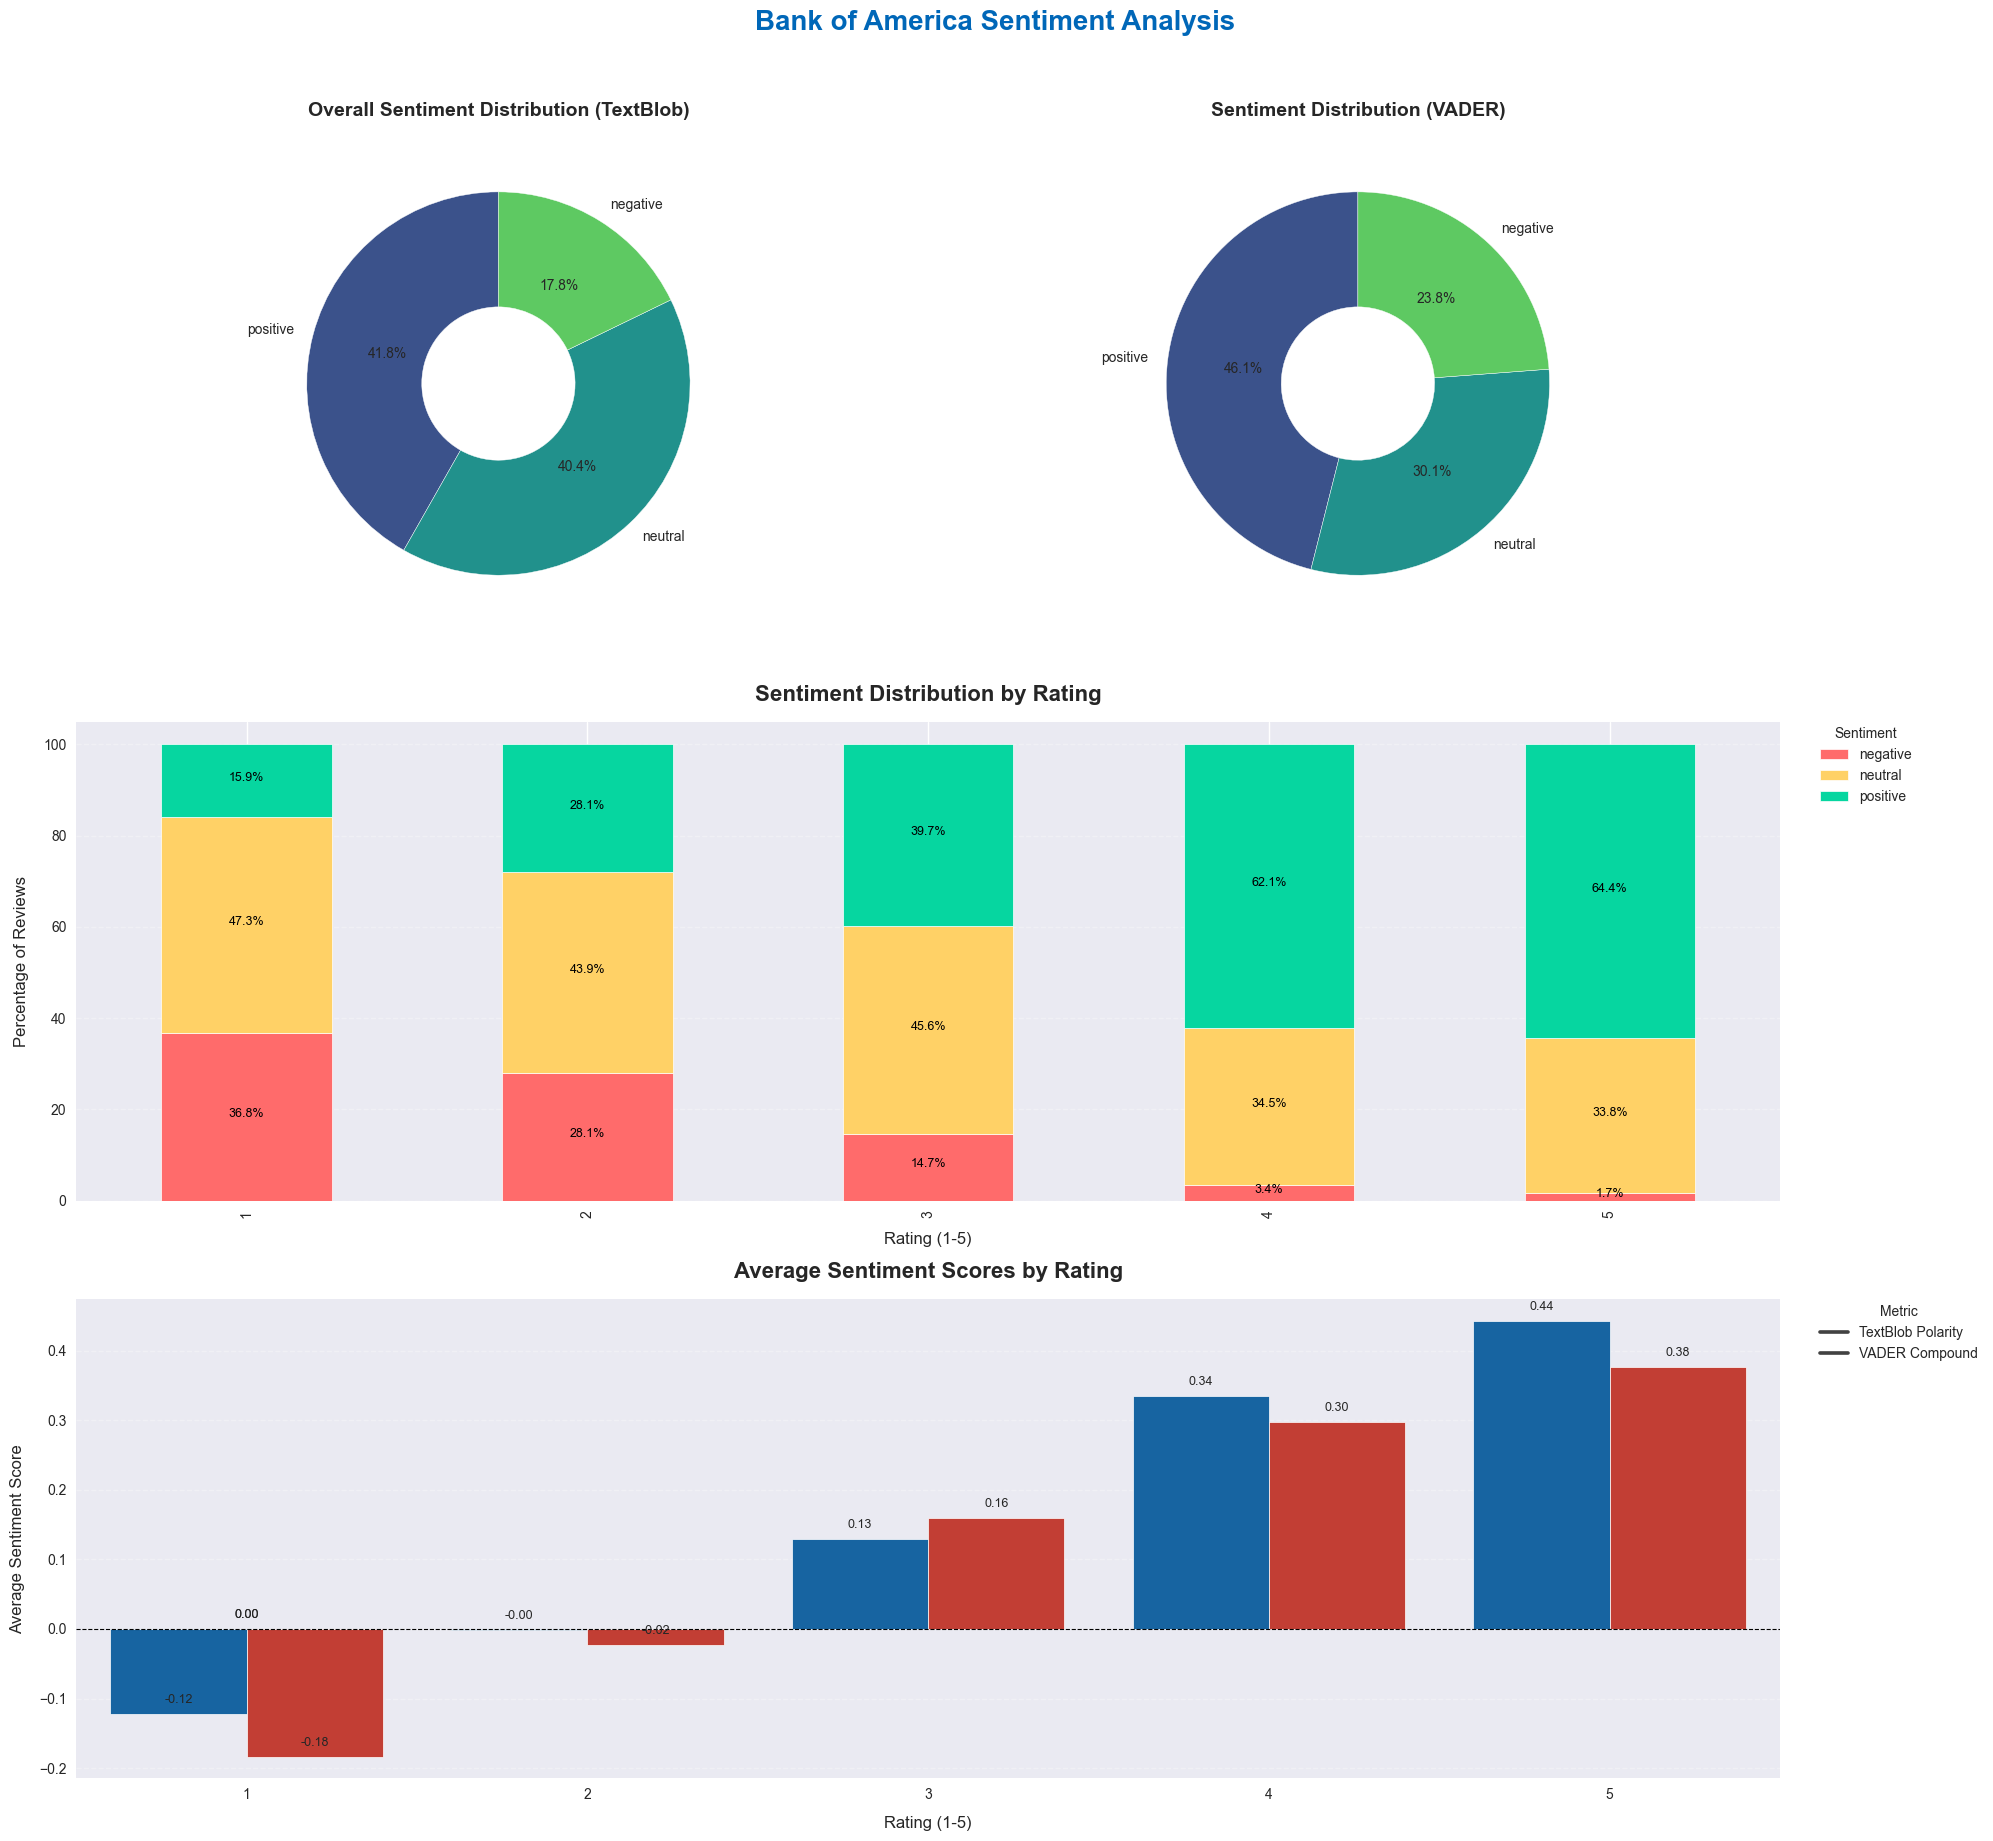

C:\Users\My Device\AppData\Local\Temp\ipykernel_12444\3644848366.py:168: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = time_series[['polarity', 'vader_compound']].resample('M').mean()


✅ Time series visualization saved to ../reports/figures\boa_sentiment_over_time.png


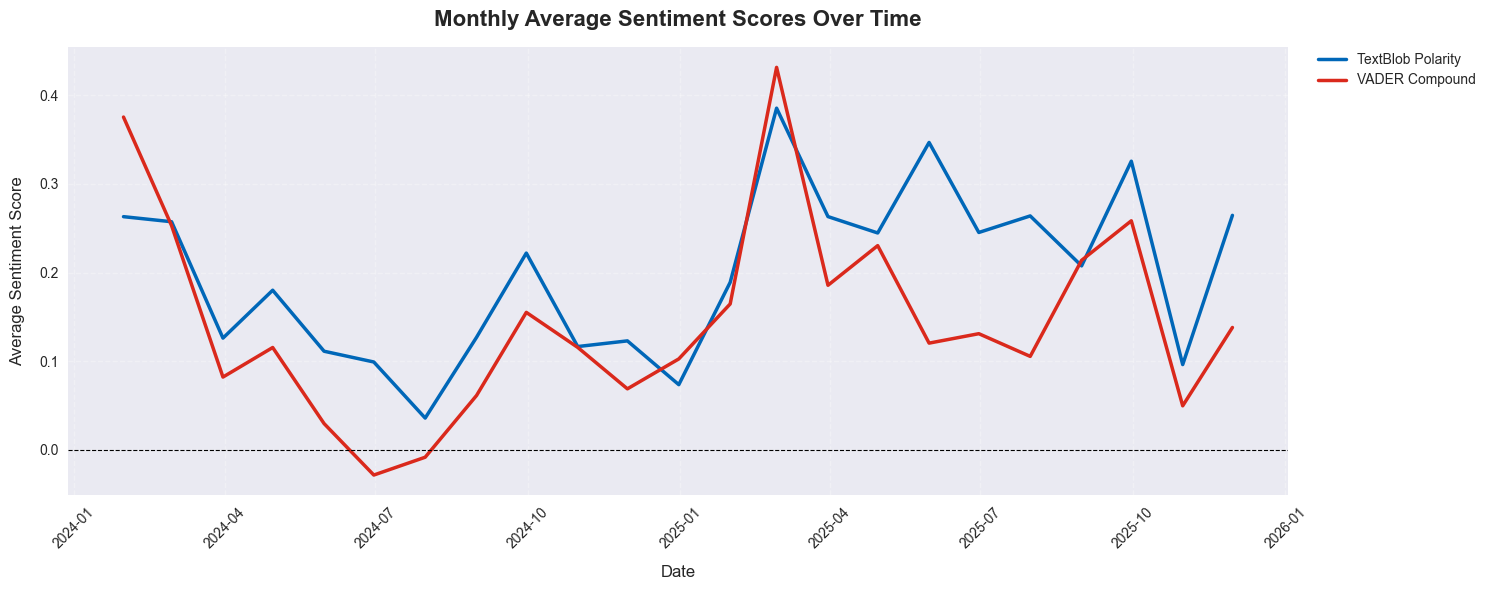

In [6]:
def plot_boa_sentiment_analysis(boa_analyzed, save_path='../reports/figures'):
    """
    Generate comprehensive visualizations for BOA sentiment analysis.
    
    Args:
        boa_analyzed (pd.DataFrame): Analyzed BOA reviews DataFrame
        save_path (str): Directory to save the visualizations
    """
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    
    # Set style and colors
    plt.style.use('seaborn-v0_8')
    sns.set_palette("viridis")
    primary_color = '#0067B8'  # BOA brand blue
    secondary_color = '#DA291C'  # BOA accent red
    
    # Create output directory if it doesn't exist
    Path(save_path).mkdir(parents=True, exist_ok=True)
    
    if boa_analyzed is None or boa_analyzed.empty:
        print("❌ No BOA data available for visualization")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(3, 2)
    fig.suptitle('Bank of America Sentiment Analysis', 
                fontsize=20, y=1.02, weight='bold', color=primary_color)
    
    # 1. Overall Sentiment Distribution (TextBlob)
    ax1 = fig.add_subplot(gs[0, 0])
    sentiment_counts = boa_analyzed['sentiment'].value_counts()
    wedges, texts, autotexts = ax1.pie(
        sentiment_counts, 
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops=dict(width=0.6, edgecolor='white'),
        colors=sns.color_palette('viridis', 3)
    )
    ax1.set_title('Overall Sentiment Distribution (TextBlob)', 
                 fontsize=14, pad=20, weight='bold')
    
    # 2. VADER Sentiment Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    vader_counts = boa_analyzed['vader_sentiment'].value_counts()
    wedges, texts, autotexts = ax2.pie(
        vader_counts, 
        labels=vader_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops=dict(width=0.6, edgecolor='white'),
        colors=sns.color_palette('viridis', 3)
    )
    ax2.set_title('Sentiment Distribution (VADER)', 
                 fontsize=14, pad=20, weight='bold')
    
    # 3. Sentiment by Rating (Stacked Bar)
    ax3 = fig.add_subplot(gs[1, :])
    if 'rating' in boa_analyzed.columns:
        sentiment_by_rating = pd.crosstab(
            boa_analyzed['rating'], 
            boa_analyzed['sentiment'],
            normalize='index'
        ) * 100
        
        sentiment_by_rating.plot(
            kind='bar', 
            stacked=True, 
            ax=ax3,
            color=['#FF6B6B', '#FFD166', '#06D6A0'],  # Red, Yellow, Green
            edgecolor='white',
            linewidth=0.5
        )
        
        # Customize the plot
        ax3.set_title('Sentiment Distribution by Rating', 
                     fontsize=16, pad=15, weight='bold')
        ax3.set_xlabel('Rating (1-5)', fontsize=12, labelpad=10)
        ax3.set_ylabel('Percentage of Reviews', fontsize=12, labelpad=10)
        ax3.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), 
                  loc='upper left', borderaxespad=0.)
        ax3.grid(axis='y', linestyle='--', alpha=0.3)
        
        # Add percentage labels on each segment
        for container in ax3.containers:
            ax3.bar_label(container, 
                         label_type='center', 
                         fmt='%.1f%%',
                         color='black',
                         fontsize=9,
                         padding=2)
    
    # 4. Average Sentiment Scores by Rating
    ax4 = fig.add_subplot(gs[2, :])
    if 'rating' in boa_analyzed.columns:
        avg_scores = boa_analyzed.groupby('rating')[
            ['polarity', 'vader_compound']
        ].mean().reset_index()
        
        # Melt for easier plotting
        melted_scores = pd.melt(
            avg_scores, 
            id_vars=['rating'], 
            var_name='metric', 
            value_name='score'
        )
        
        # Create the bar plot
        sns.barplot(
            data=melted_scores,
            x='rating',
            y='score',
            hue='metric',
            palette=[primary_color, secondary_color],
            ax=ax4,
            edgecolor='white',
            linewidth=0.5
        )
        
        # Customize the plot
        ax4.set_title('Average Sentiment Scores by Rating', 
                     fontsize=16, pad=15, weight='bold')
        ax4.set_xlabel('Rating (1-5)', fontsize=12, labelpad=10)
        ax4.set_ylabel('Average Sentiment Score', fontsize=12, labelpad=10)
        ax4.axhline(0, color='black', linewidth=0.8, linestyle='--')
        ax4.legend(title='Metric', 
                  labels=['TextBlob Polarity', 'VADER Compound'],
                  bbox_to_anchor=(1.02, 1), 
                  loc='upper left', 
                  borderaxespad=0.)
        ax4.grid(axis='y', linestyle='--', alpha=0.3)
        
        # Add value labels on top of bars
        for p in ax4.patches:
            ax4.annotate(
                f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=9
            )
    
    # Adjust layout and save
    plt.tight_layout()
    
    # Save the figure
    save_file = os.path.join(save_path, 'boa_sentiment_analysis.png')
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    print(f"✅ Visualizations saved to {save_file}")
    
    plt.show()
    
    # Additional Analysis: Sentiment Over Time (if date column exists)
    if 'date' in boa_analyzed.columns:
        plt.figure(figsize=(15, 6))
        
        # Convert to datetime and set as index
        boa_analyzed['date'] = pd.to_datetime(boa_analyzed['date'])
        time_series = boa_analyzed.set_index('date')
        
        # Resample by month and calculate mean
        monthly_avg = time_series[['polarity', 'vader_compound']].resample('M').mean()
        
        # Plot the time series
        plt.plot(monthly_avg.index, monthly_avg['polarity'], 
                label='TextBlob Polarity', color=primary_color, linewidth=2.5)
        plt.plot(monthly_avg.index, monthly_avg['vader_compound'], 
                label='VADER Compound', color=secondary_color, linewidth=2.5)
        
        # Customize the plot
        plt.title('Monthly Average Sentiment Scores Over Time', 
                 fontsize=16, pad=15, weight='bold')
        plt.xlabel('Date', fontsize=12, labelpad=10)
        plt.ylabel('Average Sentiment Score', fontsize=12, labelpad=10)
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save the time series plot
        time_series_file = os.path.join(save_path, 'boa_sentiment_over_time.png')
        plt.savefig(time_series_file, dpi=300, bbox_inches='tight')
        print(f"✅ Time series visualization saved to {time_series_file}")
        
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Assuming you have your analyzed BOA data
    # boa_analyzed = analyze_boa_sentiments(boa_data)
    
    if 'boa_analyzed' in locals() and boa_analyzed is not None:
        plot_boa_sentiment_analysis(boa_analyzed)
    else:
        print("No BOA data available for visualization")

## Analysis of BOA Sentiment by Rating

✅ Visualizations saved to ../reports/figures\boa_sentiment_by_rating.png


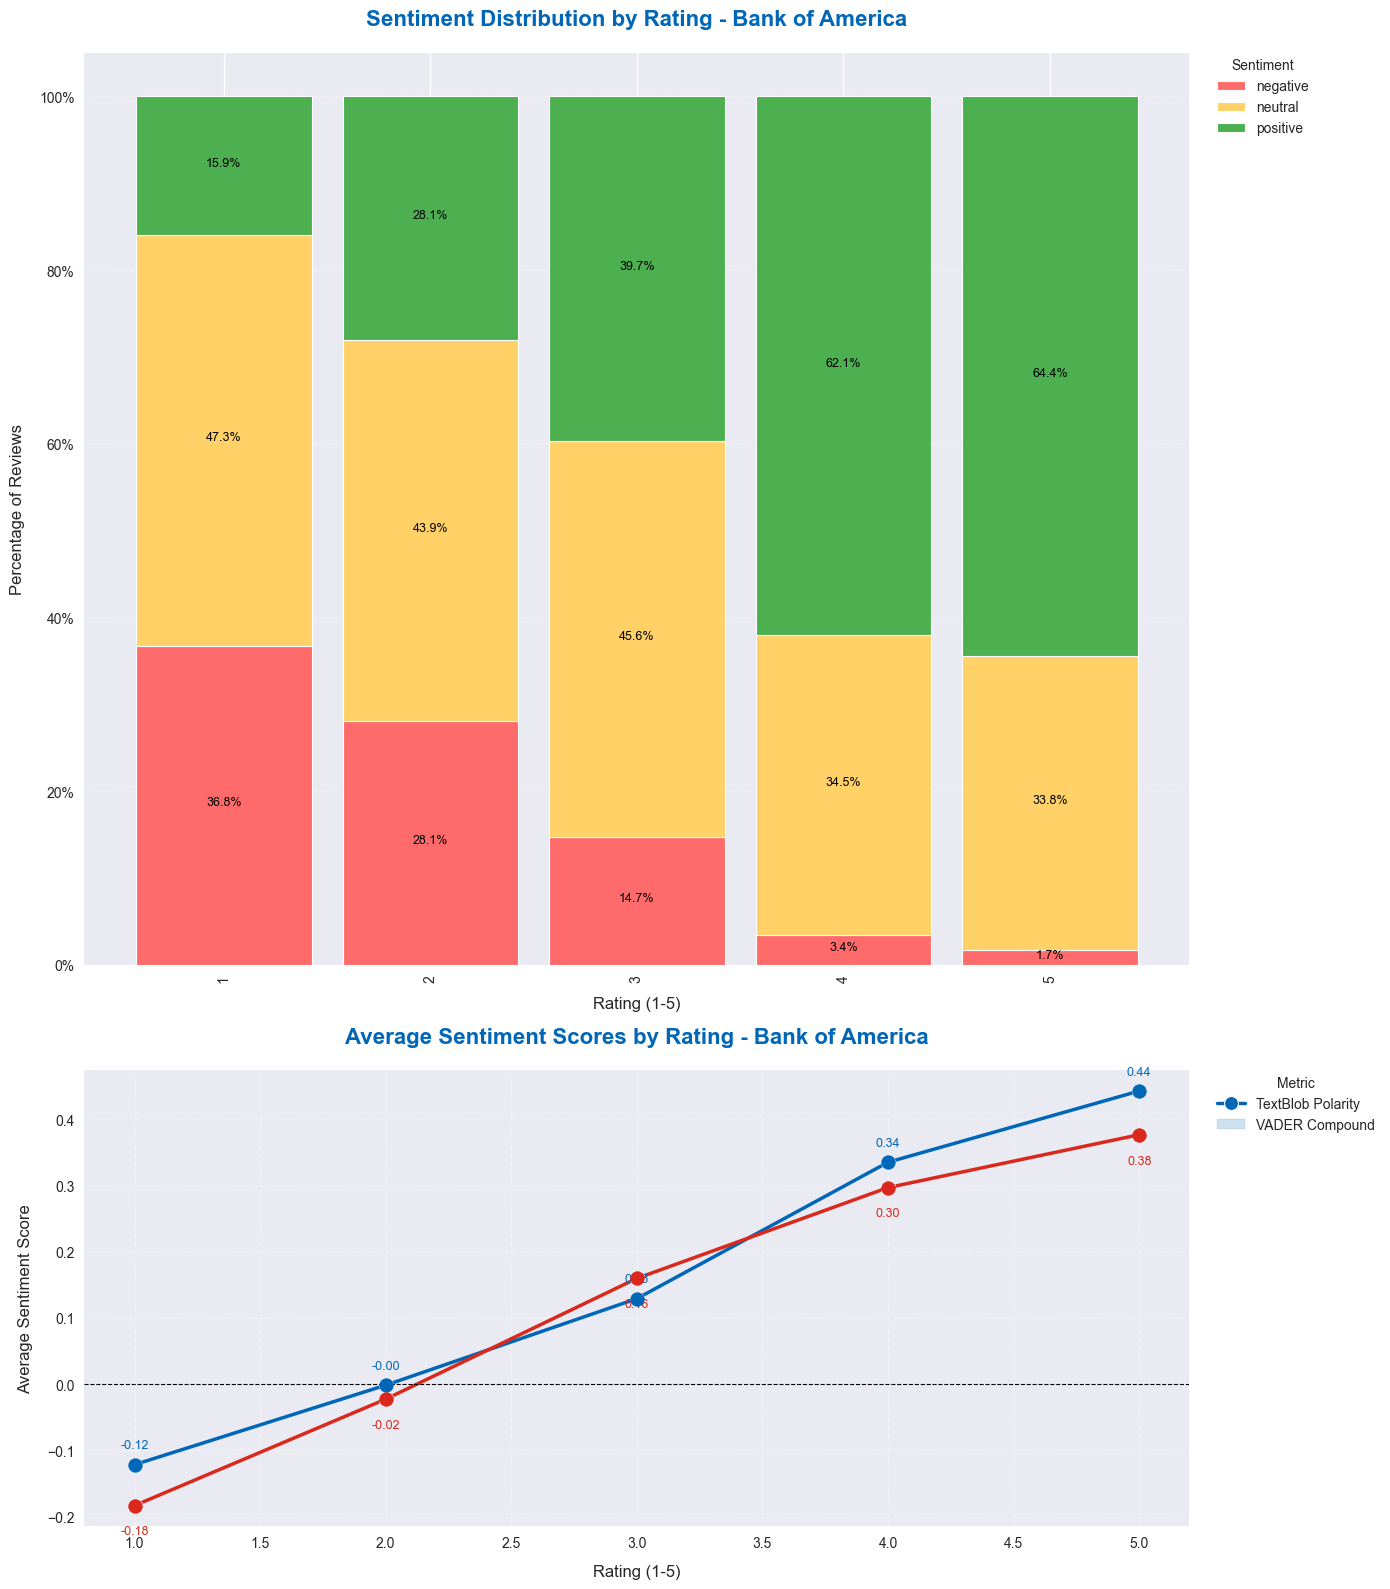


Sentiment Distribution by Rating (%):


sentiment                          
           Total Positive Neutral Negative
rating                                    
1            465     15.9    47.3     36.8
2             57     28.1    43.9     28.1
3             68     39.7    45.6     14.7
4             58     62.1    34.5      3.4
5            520     64.4    33.8      1.7

In [7]:
def plot_boa_sentiment_by_rating(boa_analyzed, save_path='../reports/figures'):
    """
    Generate detailed sentiment analysis visualizations by rating for BOA.
    
    Args:
        boa_analyzed (pd.DataFrame): Analyzed BOA reviews DataFrame
        save_path (str): Directory to save the visualizations
    """
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.ticker import PercentFormatter
    from pathlib import Path
    
    # Set style and colors
    plt.style.use('seaborn-v0_8')
    sns.set_palette("viridis")
    primary_color = '#0067B8'  # BOA blue
    secondary_color = '#DA291C'  # BOA red
    success_color = '#4CAF50'  # Green for positive sentiment
    
    # Create output directory if it doesn't exist
    Path(save_path).mkdir(parents=True, exist_ok=True)
    
    if boa_analyzed is None or boa_analyzed.empty:
        print("❌ No BOA data available for visualization")
        return
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16), 
                                  gridspec_kw={'height_ratios': [2, 1]})
    
    # 1. Sentiment Distribution by Rating (Stacked Bar Chart)
    if 'rating' in boa_analyzed.columns:
        # Create cross-tabulation
        sentiment_by_rating = pd.crosstab(
            boa_analyzed['rating'], 
            boa_analyzed['sentiment'],
            normalize='index'
        ) * 100
        
        # Plot stacked bars
        sentiment_by_rating.plot(
            kind='bar', 
            stacked=True, 
            ax=ax1,
            color=['#FF6B6B', '#FFD166', success_color],  # Red, Yellow, Green
            edgecolor='white',
            linewidth=0.8,
            width=0.85
        )
        
        # Customize the plot
        ax1.set_title('Sentiment Distribution by Rating - Bank of America', 
                     fontsize=16, pad=20, weight='bold', color=primary_color)
        ax1.set_xlabel('Rating (1-5)', fontsize=12, labelpad=10)
        ax1.set_ylabel('Percentage of Reviews', fontsize=12, labelpad=10)
        ax1.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), 
                  loc='upper left', borderaxespad=0.)
        ax1.grid(axis='y', linestyle='--', alpha=0.3)
        ax1.yaxis.set_major_formatter(PercentFormatter(100))
        
        # Add percentage labels on each segment
        for container in ax1.containers:
            ax1.bar_label(container, 
                         label_type='center', 
                         fmt='%.1f%%',
                         color='black',
                         fontsize=9,
                         padding=2)
    
    # 2. Average Sentiment Scores by Rating (Line Plot)
    if 'rating' in boa_analyzed.columns:
        # Calculate average scores
        avg_scores = boa_analyzed.groupby('rating')[
            ['polarity', 'vader_compound']
        ].mean().reset_index()
        
        # Create line plot
        sns.lineplot(
            data=pd.melt(avg_scores, id_vars='rating', 
                        var_name='metric', value_name='score'),
            x='rating',
            y='score',
            hue='metric',
            style='metric',
            markers=True,
            dashes=False,
            markersize=10,
            linewidth=2.5,
            palette=[primary_color, secondary_color],
            ax=ax2
        )
        
        # Customize the plot
        ax2.set_title('Average Sentiment Scores by Rating - Bank of America', 
                     fontsize=16, pad=20, weight='bold', color=primary_color)
        ax2.set_xlabel('Rating (1-5)', fontsize=12, labelpad=10)
        ax2.set_ylabel('Average Sentiment Score', fontsize=12, labelpad=10)
        ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
        ax2.legend(
            title='Metric',
            labels=['TextBlob Polarity', 'VADER Compound'],
            bbox_to_anchor=(1.02, 1), 
            loc='upper left', 
            borderaxespad=0.
        )
        ax2.grid(True, linestyle='--', alpha=0.3)
        
        # Add data points
        for metric in ['polarity', 'vader_compound']:
            ax2.scatter(
                avg_scores['rating'],
                avg_scores[metric],
                color=primary_color if metric == 'polarity' else secondary_color,
                s=100,
                zorder=5
            )
        
        # Add value labels
        for _, row in avg_scores.iterrows():
            ax2.text(
                row['rating'], 
                row['polarity'] + 0.02, 
                f"{row['polarity']:.2f}",
                ha='center',
                va='bottom',
                fontsize=9,
                color=primary_color
            )
            ax2.text(
                row['rating'], 
                row['vader_compound'] - 0.03, 
                f"{row['vader_compound']:.2f}",
                ha='center',
                va='top',
                fontsize=9,
                color=secondary_color
            )
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    save_file = os.path.join(save_path, 'boa_sentiment_by_rating.png')
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    print(f"✅ Visualizations saved to {save_file}")
    
    plt.show()
    
    # 3. Create a detailed table of sentiment distribution
    if 'rating' in boa_analyzed.columns:
        # Calculate statistics
        stats = boa_analyzed.groupby('rating').agg({
            'sentiment': [
                ('Total', 'count'),
                ('Positive', lambda x: (x == 'positive').mean() * 100),
                ('Neutral', lambda x: (x == 'neutral').mean() * 100),
                ('Negative', lambda x: (x == 'negative').mean() * 100)
            ]
        }).round(1)
        
        # Display the table
        print("\nSentiment Distribution by Rating (%):")
        display(stats)

# Example usage:
if __name__ == "__main__":
    # Assuming you have your analyzed BOA data
    # boa_analyzed = analyze_boa_sentiments(boa_data)
    
    if 'boa_analyzed' in locals() and boa_analyzed is not None:
        plot_boa_sentiment_by_rating(boa_analyzed)
    else:
        print("No BOA data available for visualization")

## Save Analysis Results

In [11]:
def save_boa_analysis(boa_analyzed, output_dir='../reports/boa'):
    """
    Save BOA analysis results to a CSV file.
    
    Args:
        boa_analyzed (pd.DataFrame): Analyzed BOA reviews DataFrame
        output_dir (str): Directory to save the output file
    """
    from pathlib import Path
    from datetime import datetime
    
    if boa_analyzed is None or boa_analyzed.empty:
        print("❌ No BOA data to save")
        return None
    
    try:
        # Create output directory if it doesn't exist
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Create filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"sentiment_analysis_boa_{timestamp}.csv"
        filepath = output_path / filename
        
        # Save to CSV
        boa_analyzed.to_csv(filepath, index=False)
        print(f"✅ Saved {len(boa_analyzed)} records to {filepath}")
        return str(filepath)
        
    except Exception as e:
        print(f"❌ Error saving BOA analysis: {str(e)}")
        return None

# Example usage:
if __name__ == "__main__":
    # Assuming you have your analyzed BOA data
    # boa_analyzed = analyze_boa_sentiments(boa_data)
    
    if 'boa_analyzed' in locals() and boa_analyzed is not None:
        saved_file = save_boa_analysis(boa_analyzed)
        if saved_file:
            print(f"Analysis saved to: {saved_file}")
    else:
        print("No BOA data available to save")

✅ Saved 1168 records to ..\reports\boa\sentiment_analysis_boa_20251129_155659.csv
Analysis saved to: ..\reports\boa\sentiment_analysis_boa_20251129_155659.csv


## Generate Summary Report

In [12]:
def generate_boa_summary(boa_analyzed, output_file='../reports/boa_sentiment_summary.md'):
    """Generate a markdown summary report for BOA sentiment analysis"""
    from pathlib import Path
    from datetime import datetime
    
    if boa_analyzed is None or boa_analyzed.empty:
        print("❌ No BOA data available for report generation")
        return

    # Setup output directory
    report_path = Path(output_file)
    report_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Calculate statistics
    total = len(boa_analyzed)
    tb_sent = boa_analyzed['sentiment'].value_counts()
    vd_sent = boa_analyzed['vader_sentiment'].value_counts()
    rating_dist = boa_analyzed['rating'].value_counts().sort_index() if 'rating' in boa_analyzed else {}
    date_range = f"{boa_analyzed['date'].min()} to {boa_analyzed['date'].max()}" if 'date' in boa_analyzed else "N/A"

    # Generate report
    report = f"""# Bank of America Sentiment Analysis Report

## Overview
This report summarizes the sentiment analysis of {total:,} BOA reviews.

## Key Statistics
- **Total Reviews**: {total:,}
- **Date Range**: {date_range}

## Sentiment Analysis

### TextBlob Analysis
{f"- Positive: {tb_sent.get('positive', 0):,} ({(tb_sent.get('positive', 0)/total):.1%})"}
{f"- Neutral: {tb_sent.get('neutral', 0):,} ({(tb_sent.get('neutral', 0)/total):.1%})"}
{f"- Negative: {tb_sent.get('negative', 0):,} ({(tb_sent.get('negative', 0)/total):.1%})"}

### VADER Analysis
{f"- Positive: {vd_sent.get('positive', 0):,} ({(vd_sent.get('positive', 0)/total):.1%})"}
{f"- Neutral: {vd_sent.get('neutral', 0):,} ({(vd_sent.get('neutral', 0)/total):.1%})"}
{f"- Negative: {vd_sent.get('negative', 0):,} ({(vd_sent.get('negative', 0)/total):.1%})"}

## Rating Distribution
{chr(10).join(f"- {star}★: {count:,} ({(count/total):.1%})" for star, count in rating_dist.items())}

## Visualizations
![Sentiment by Rating](../reports/figures/boa_sentiment_by_rating.png)
![Average Scores](../reports/figures/boa_avg_scores_by_rating.png)

---

*Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""

    # Save the report
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report)
    
    print(f"✅ Report generated: {report_path}")

# Example usage:
if __name__ == "__main__":
    if 'boa_analyzed' in locals() and boa_analyzed is not None:
        generate_boa_summary(boa_analyzed)
    else:
        print("No BOA data available for report generation")

✅ Report generated: ..\reports\boa_sentiment_summary.md
